# Example X: Estimation of spectra from time series data


This example gives an overview of estimation of spectra from time series data. In application of structural dynamics, we have to bridge the gap between time domain and the frequency domain.

Consider that we have a time series $x(t)$ of the response of a structure. This time series may come from computer simulations, or be a measured at a structure using accelerometers. We will generally assume that the data comes from a stationary stochastic process. This means that $x(t)$ is one realization of the stochastic process.

We now wish to estimate the spectrum $S_{x}(\omega)$. We use the term *estimate* since we cannot really know the exact spectrum unless we have an infinitely long time series without any measurement noise. There are many ways to perform the estimation: two basic methods are demonstrated here.





## Method 1: FFT

The first method is the simplest and is based on the Fourier transform $X(\omega)$. 

We simply find the spectrum as 

$$ S_{x}(\omega) = T \cdot X(\omega) \bar{X}(\omega) = T \cdot |X(\omega)|^2$$

where $\bar{(~)}$ denotes the complex conjugate and $T$ is the length of the time series signal (in seconds). To find the Fourier transform $X(\omega)$ of a time series we use the FFT algorithm, which is standard in every computer language. To see why it is so simple, consider the following derivation:

We know that the spectrum is the Fourier transform of the auto correlation function:

$$ S_{x}(\omega) = \frac{1}{2\pi} \int_{-\infty}^{\infty} R_{xx}(\tau) e^{-i\omega\tau} d\tau $$

The auto correlation function could be found by averaging over an infinitely long time series:

$$R_{x}(\tau)=E[ x(t) x(t+\tau) ] = \frac{1}{T} \int_{-T/2}^{T/2}  x(t) x(t+\tau) dt, \quad T \rightarrow \infty $$



Inserted:

$$ S_{x}(\omega) = \frac{1}{2\pi} \frac{1}{T} \int_{-\infty}^{\infty}  \int_{-T/2}^{T/2}  x(t) x(t+\tau)   e^{-i\omega\tau} dt  d\tau $$

Next, we change integration variables $\alpha=t, \beta=t+\tau$, and split the double integral into two single integrals:

$$ S_{x}(\omega) = \frac{1}{2\pi} \frac{1}{T} \int_{-\infty}^{\infty}  \int_{-\infty}^{\infty}  x(\alpha) x(\beta)  e^{i\omega\alpha} e^{-i\omega\beta} d\alpha d\beta
 = \frac{1}{2\pi} 
 \frac{1}{T} 
\underbrace{
\big(
\int_{-\infty}^{\infty} x(\alpha)  e^{i\omega\alpha}  d\alpha
\big)
}_{\bar{X}(\omega)}
\underbrace{
\big(
\int_{-\infty}^{\infty} x(\beta)  e^{-i\omega\beta}  d\beta
\big)
}_{X(\omega)}
=
 \frac{1}{2\pi T}  X(\omega)\bar{X}(\omega)
$$

???: 2PI IN FRONT AND OTHER NORMALIZATION NEED TO BE CHECKED.


NB! Due to different definitions of the FFT, the normalization of the equation above might change. The scaling of the spectrum by a constant value does not change its overall shape. The peaks and dips of the spectrum will still be located at the same frequencies.

We will now simulate a time series, and then estimate the spectrum of the process. Note that we are "cheating" a bit here, since we know the exact spectrum of the process to begin with.

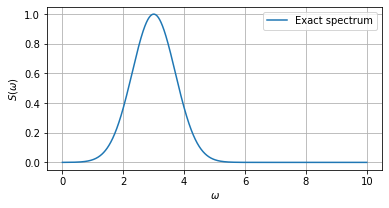

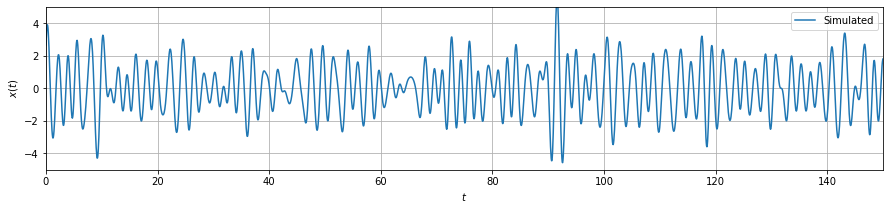

In [29]:
# Simulate time series from a known spectrum

import numpy as np
from matplotlib import pyplot as plt

# Bell-shaped spectrum
w = np.linspace(0,10,20000);
Sx = np.exp( -(w-3)**2)

# Plot the spectrum
plt.figure(figsize=(6,3))   
plt.plot(w,Sx,'-' ,label = 'Exact spectrum') 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.grid()
plt.legend()

phi = np.random.rand(w.shape[0])*2*np.pi # Random phase angles 
t = np.linspace(0,600,10000) # Time vector
x = np.zeros(t.shape[0]) # Initialize the vector of x values
domega = w[1]-w[0] # Frequency spacing
for k in range(w.shape[0]):
    Ak = (2*Sx[k]*domega)**0.5 #Amplitude
    x = x + Ak * np.cos(w[k]*t+ phi[k]) # Sum the contibution from each harmonic component
    
# Plot part of the simulated time series
plt.figure(figsize=(15,3))
plt.plot(t,x,label = 'Simulated')
plt.ylabel(r'$x(t)$')
plt.xlabel(r'$t$')
plt.xlim(0,150)
plt.ylim(-5,5)
plt.grid()
plt.legend()


We will now use the FFT method for the spectrum. We may call this the estimated spectrum or the empirical spectrum.

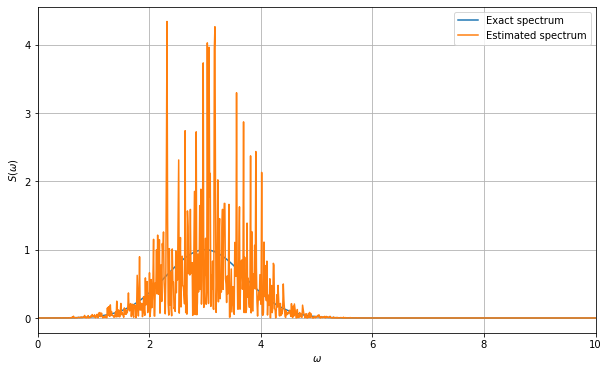

In [30]:

# Function for FFT
def fft_function(x,dt,axis=0):
    """
    This function gives the DFT
    
    Arguments
    ---------------------------
    x : double
         time series
    dt : double
         resolution of the time axis
    axis : double
         the axis on which the DFT operates 
         
    Returns
    ---------------------------
    f : double
        frequency axis
    G : double
        DFT (complex Fourier coefficients)

        
    Reference: 
      
    """
    
    n=np.shape(x)
    n_points=n[axis]
    
    G=np.fft.fftshift( np.fft.fft(x,None,axis) )/n_points
   
    # Sampling frequency
    Fs=1/np.double(dt)
    
    # Frequency axis
    f=Fs/2*np.linspace(-1,1,n_points)
    
    return f,G


dt=t[1]-t[0] # Time increment
T=t[-1] # Total measurement period

f,X=fft_function(x,dt) # Find FFT and corresponding frequency axis

Sx_est_temp=T*np.real(np.multiply(X,np.conj(X))) # Estimate spectrum (two-sided and function of Hz)

w_est=f[f>0]*2*np.pi # One-sided frequency axis in rad/s
Sx_est=Sx_est_temp[f>0]/(2*np.pi)*2 # One-sided spectrum as function of rad/s

# Plot and compare with exact solution
plt.figure(figsize=(10,6))   
plt.plot(w,Sx,'-' ,label = 'Exact spectrum') 
plt.plot(w_est,Sx_est,'-' ,label = 'Estimated spectrum') 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,10)
plt.grid()
plt.legend()



We see that the two spectra generally match, but that the estimated spectrum is very "noisy". This depends on the length of the time series, ideally it should be infinitely long. This is, however, not feasible. How to improve the quality? If we have multiple realizations of $x(t)$, we could estimate the spectrum for each time series, and then produce the averaged spectrum. We don't always have multiple data available. The next method will produce a much more smooth spectrum.

## Method 2: Welch's method

Welch's method works by dividing the time series into a number of segments as shown in the figure below. The number of divisions (or equivalently, the length of each segment) is defined by the user. The segments can also overlap, and a 50% overlap is usually chosen (default setting in Python and Matlab). 

The spectrum is calculated by the FFT method for each segment, and finally the averaged spectrum is the Welch estimate. Since this is an averaging method, the noisy behavior in the previous method will to a large extent be mitigated.

<img src=".\figures\Fig_welch.png" width="500px">


How to chose the number of divisions? This is a trade-off with advantages and disadvantages. 

- More divisions (=shorter segments) leads to greater averaging and thus a smoother spectrum. However, the frequency resolution $\Delta f$ or $\Delta \omega$ in the frequency axis becomes bigger. 
- Less divisions (=longer segments) leads to less averaging and thus a more noisy spectrum. The advantage is that the frequency resolution is finer.

We may observe these effects if the code example below is changed.

Other useful settings to consider:

- Windowing: the time series of each segment is weighted by a so-called Hanning window. The details are not explained here, but this is done to reduce end effects.
- NFFT: this zero pads the time series to a given length. For instance, if the time series is 200 points long, setting NFFT=256=2^8 will add 56 zeros at the end. This is done because the FFT algorithm is fastest when the length is a power of two.
- Return one-sided: this is usually convenient to do, can be turned off if a two-sided spectrum is sought.
- Detrend: a detrending of the time series is recommended, this means to subtract the mean value so that it becomes zero mean. If turned off, the spectrum will have a peak at 0 Hz corresponding to a static component in the process.













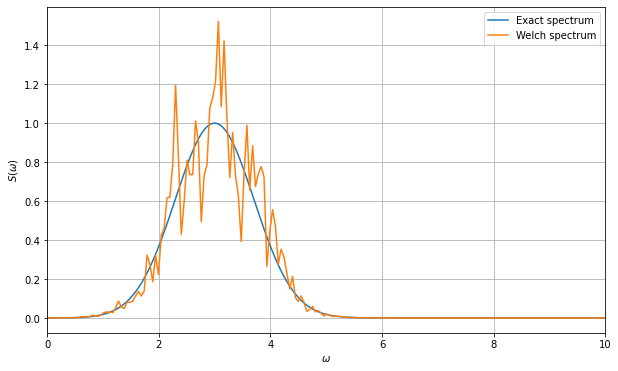

In [35]:
from scipy.signal import hanning
import scipy

Ndivisions=5 # Number of divisions of the time series (total segments)
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window/segment

Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2 for zero padding

# Call welch from scipy signal processing
f, Sxx_welch_temp=scipy.signal.welch(x, fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=- 1, average='mean')

w_welch=f*2*np.pi # Transform to rad/s
Sxx_welch=Sxx_welch_temp/(2*np.pi) # Transform to rad/s

# Plot and compare with exact solution
plt.figure(figsize=(10,6))   
plt.plot(w,Sx,'-' ,label = 'Exact spectrum') 
plt.plot(w_welch,Sxx_welch,'-' ,label = 'Welch spectrum') 
plt.xlabel('$\omega$')
plt.ylabel('$S(\omega)$')
plt.xlim(0,10)
plt.grid()
plt.legend()



From the figure above, you see that the Welch spectrum matches quite well. The estimated spectrum is much smoother, but this comes at the cost of a reduced spectral precision (frequency resolution) compared to the FFT method.

## Cross-spectral densities

Until this point, we have only considered auto spectra. When we deal with cross-spectra, or a *cross-spectral density matrix*, we usually arrange the data as a 3d array shown in the figure below. The two first dimensions represent the DOF dimensions, while the last is the frequency dimension. To obtain the cross-spectral density matrix at one specific frequency, we have to select a "slice" of the 3d array.


<img src=".\figures\Fig_spectrum_3d_array.png" align = "center" style="width:500px" >


The code below shows how to construct the cross spectral density matrix. We call the *csd* function in a double foor loop, this is the same as *welch* except that it takes in two signals $x(t)$ and $y(t)$. If $x=y$, then an auto specter is obtained.

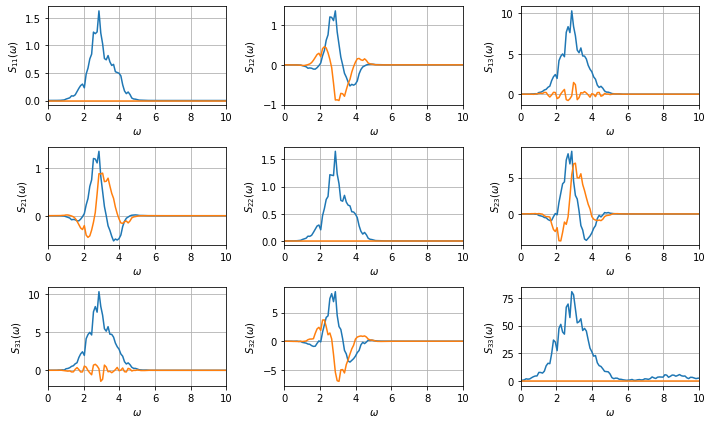

In [25]:
# Welch estimate of cross-spectral density

# Lets create a vector y with data consisting of three sources:
#i) x; ii) x shifted by 40 points;  iii) x^3
y=np.vstack((x,np.roll(x,40),x**3))

Ndivisions=10 # Number of divisions of the time series
Nwindow=np.ceil(len(t)/Ndivisions) # Length of window
Nfft_pow2 = 2**(np.ceil(np.log2(Nwindow))) # Next power of 2

# Spectral matrix
S_welch=np.zeros((3,3,np.int32(Nfft_pow2/2+1)),dtype=np.complex_)

# Fill spectral matrix by taking the cross spectral density between each of the 3 time series
for k1 in range(3):
    for k2 in range(3):
            f, S_Hz=scipy.signal.csd(y[k1,:],y[k2,:], fs=1/dt, window='hann', nperseg=Nwindow, noverlap=None, nfft=Nfft_pow2, detrend='constant', return_onesided=True, scaling='density', axis=-1, average='mean')
            
            w_welch=f*2*np.pi # Frequency axis in rad/s
            S_welch[k1,k2,:]=S_Hz/(2*np.pi) # Spectrum in rad/s
            
# Plot spectrum
fig, axs = plt.subplots(3,3,figsize=(10,6))    
for k1 in range(3):
    for k2 in range(3):
        ax = axs[k1,k2]
        ax.plot(w_welch,np.real(S_welch[k1,k2,:]))
        ax.plot(w_welch,np.imag(S_welch[k1,k2,:]))
        ax.set_ylabel(('$S_{' + str(k1+1) + str(k2+1) + '}(\omega)$'))
        ax.set_xlabel('$\omega$')
        ax.grid(True)
        #ax.set_yscale('log')
        ax.set_xlim(0,10)
plt.tight_layout()

